In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from typing import Set, List, Dict, Tuple

import json
from datetime import datetime, timezone
from collections import Counter

import pba.parse as ps
from pba.prediction import Prediction, Response
from pba.analysis import actions_per_day, bin_actions_by_period, predictions_per_user, brier_scores_by_user

import numpy as np
import seaborn as sns
from tqdm import tqdm

sns.set(rc={'figure.figsize':(12, 9*0.75)})

In [7]:
json_file = "/home/david/proj/pba/data/predictions.json"
preds = ps.load_json_to_predictions(json_file)
responses = [resp for pred in preds for resp in pred.responses]

100%|██████████| 16092/16092 [01:31<00:00, 176.59it/s]


In [4]:
# Example prediction

print(preds[3588].show())

----
Event: Unequally Yoked: Ideological Turing Test -
Christian Entry #9 is written by an atheist.
Outcome: wrong
User: modernalgebra
#: 20768
Time created: 2013-07-26 22:37:47+00:00
Time known: 2013-09-01 12:00:00+00:00

  * modernalgebra (2013-07-26 22:37:47+00:00) 
    * credence: 15
  * modernalgebra (2013-09-25 02:49:42+00:00) 
    * outcome: wrong
----



# Basic statistics
- number of predictions
- number of comments, credences, past-due predictions, judged predictions (w/ right and wrong #s)
- avg length of a comment
- how many predictions are private
- number of unique users

In [5]:
# number of predictions, how many have were judged, correct, incorrect, private?

unknown = [p for p in preds if p.unknown()]
correct = [p for p in preds if p.right()]
wrong = [p for p in preds if p.wrong()]

all_preds = max(int(p.number) for p in preds)

print(f"There are {len(preds)} predictions.")
print(f"{round(100 * len(unknown) / len(preds))}% of them are still to be decided.")
print(f"{round(100 * len(correct) / len(preds))}% of them were judged correct.")
print(f"{round(100 * len(wrong) / len(preds))}% of them were judged incorrect.")
print(f"Under naive assumptions, there have been {all_preds} predictions, of which {round(100* len(preds) / all_preds)}% are public.")

There are 16092 predictions.
22% of them are still to be decided.
32% of them were judged correct.
42% of them were judged incorrect.
Under naive assumptions, there have been 196985 predictions, of which 8% are public.


In [6]:
# number of comments, credences, past-due predictions
past_due = [p for p in preds if p.unknown() and p.time_known < datetime.now(timezone.utc)]
credences = [len(p.credences()) for p in preds]
comments = [len(p.comments()) for p in preds]
comment_lens = [len(c) for p in preds for c in p.comments()]

print(f"There are {len(past_due)} past due predictions, representing {round(100 * len(past_due) / len(preds))}% of all predictions")
print(f"There are {sum(credences)} total credences, with an average of {round(np.mean(credences), 2)} credences per prediction.")
print(f"There are {sum(comments)} total comments, with an average of {round(np.mean(comments), 2)} comments per prediction.")
print(f"The average comment length is {round(np.mean(comment_lens))} characters.")

There are 595 past due predictions, representing 4% of all predictions
There are 53618 total credences, with an average of 3.33 credences per prediction.
There are 24765 total comments, with an average of 1.54 comments per prediction.
The average comment length is 125.0 characters.


In [7]:
users : Set[str] = {resp.user for resp in responses}
print(f"There are {len(users)} unique users who have been active on the site.")

There are 2040 unique users who have been active on the site.


## User Distributions

In [19]:
user_predictions : Dict[str, List[Prediction]] = {
    user: [pred for pred in preds if pred.user == user] for user in users}
user_responses : Dict[str, List[Response]] = {
    user: [resp.actions['credence'] for resp in responses if (resp.user == user 
                                                              and 'credence' in resp.actions)] 
    for user in users}

In [20]:
def users_who_gave_credences(pred):
    '''How many unique users gave a credence for this prediction?'''
    cred_users = [resp.user for resp in pred.responses if "credence" in resp.actions]
    return len(set(cred_users))

num_cred_dist = [users_who_gave_credences(pred) for pred in preds if not pred.unknown()]

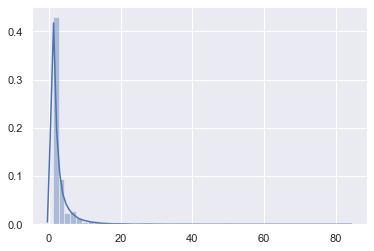

In [21]:
sns.distplot(num_cred_dist)

In [22]:
# Top 25 most prolific
print(predictions_per_user(preds).most_common(25))

gwern_pct = round(100 * predictions_per_user(preds)['gwern'] / len(preds))
print(f"So gwern alone accounts for {gwern_pct}% of all predictions")

[('gwern', 1809), ('Cato', 855), ('themusicgod1', 631), ('JoshuaZ', 449), ('Jayson Virissimo', 433), ('RandomThinker', 366), ('KnaveOfAllTrades', 349), ('jbeshir', 336), ('bobpage', 282), ('musashimaru', 276), ('InquilineKea', 250), ('sweeneyrod', 230), ('EloiseRosen', 224), ('Raahul_Kumar', 220), ('Anubhav', 195), ('NathanMcKnight', 185), ('RoryS', 161), ('ioannes', 153), ('Bruno Parga', 133), ('notsonewuser', 133), ('Vipul Naik', 131), ('two2thehead', 128), ('Michael Dickens', 126), ('splorridge', 121), ('qwerty314', 118)]
So gwern alone accounts for 11% of all predictions


In [12]:
len(bin_actions_by_period(actions_per_day(preds), period_type="Year"))

12

# Site Activity Over Time

/home/david/.conda/envs/pba/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


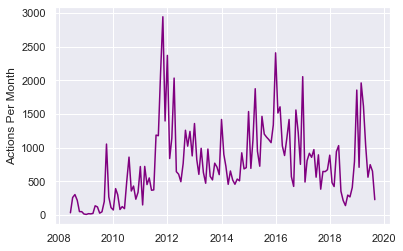

In [13]:
period_type = "Month"

dates, activity = zip(*bin_actions_by_period(actions_per_day(preds), period_type=period_type))

ax = sns.lineplot(x=dates, y=activity, color="purple", markers=False, dashes=True)
ax.set(ylabel=f"Actions Per {period_type}")

ax.get_figure().savefig("../results/activity.png")

# Calibration Over Time

Calibration is roughly to brier scores as bias is to variance. 

We want x: days since first credence, y: calibration of all credences given at x days since user's first credence

This possibly means that we'll be only looking at people who stuck with the site because they were successful.

We could instead look at people who have given at least K credences, over at least D days, calculate the slope of calibration for each one, and average the slopes?

### What does calibration mean?

We bin credences into 50-60, 60-70, etc. Then, for each bin, we sum(abs(pct_correct_in_bin - mean_credence_in_bin)) and add the results up

There are probably better approaches?

In [35]:
resolved_credences: Dict[int, List[Tuple[bool, float]]] = an.resolved_credences(preds)

In [38]:
an.calibration_score(resolved_credences[100])

46.224000000000004

In [39]:
import pba.analysis as an


print(resolved_credences)
[(days_since, len(resolved_credences[days_since])) for days_since in range(max(resolved_credences))][:200]

defaultdict(<class 'list'>, {1316: [(True, 70), (False, 40), (False, 1), (False, 0), (False, 70), (False, 50), (True, 91)], 207: [(True, 60), (False, 0), (True, 58), (False, 35), (True, 99), (False, 0), (True, 10), (False, 47), (False, 1), (True, 75), (False, 10), (True, 85), (False, 25), (True, 70), (False, 25), (False, 30), (False, 17), (True, 16), (False, 55), (False, 35), (True, 80), (True, 30)], 972: [(True, 75)], 1128: [(True, 85)], 0: [(True, 70), (True, 85), (True, 65), (False, 50), (True, 33), (True, 60), (False, 10), (True, 70), (True, 20), (True, 40), (True, 45), (True, 30), (True, 85), (False, 75), (False, 30), (False, 50), (False, 70), (False, 41), (False, 60), (False, 5), (False, 10), (False, 20), (False, 10), (True, 75), (True, 90), (True, 100), (False, 90), (False, 5), (True, 30), (True, 25), (True, 40), (True, 30), (True, 28), (True, 60), (True, 90), (True, 90), (True, 100), (False, 45), (False, 5), (False, 80), (False, 20), (True, 99), (False, 50), (True, 85), (False,

[(0, 4991),
 (1, 691),
 (2, 309),
 (3, 251),
 (4, 221),
 (5, 213),
 (6, 151),
 (7, 184),
 (8, 118),
 (9, 139),
 (10, 124),
 (11, 130),
 (12, 173),
 (13, 166),
 (14, 203),
 (15, 81),
 (16, 121),
 (17, 156),
 (18, 115),
 (19, 96),
 (20, 114),
 (21, 123),
 (22, 84),
 (23, 103),
 (24, 60),
 (25, 85),
 (26, 117),
 (27, 98),
 (28, 131),
 (29, 111),
 (30, 104),
 (31, 104),
 (32, 88),
 (33, 54),
 (34, 83),
 (35, 97),
 (36, 108),
 (37, 92),
 (38, 90),
 (39, 79),
 (40, 110),
 (41, 85),
 (42, 51),
 (43, 106),
 (44, 74),
 (45, 92),
 (46, 76),
 (47, 35),
 (48, 79),
 (49, 86),
 (50, 66),
 (51, 53),
 (52, 58),
 (53, 74),
 (54, 78),
 (55, 57),
 (56, 35),
 (57, 41),
 (58, 32),
 (59, 58),
 (60, 76),
 (61, 92),
 (62, 53),
 (63, 51),
 (64, 63),
 (65, 61),
 (66, 30),
 (67, 70),
 (68, 46),
 (69, 30),
 (70, 32),
 (71, 52),
 (72, 39),
 (73, 76),
 (74, 44),
 (75, 26),
 (76, 32),
 (77, 35),
 (78, 39),
 (79, 28),
 (80, 70),
 (81, 60),
 (82, 64),
 (83, 63),
 (84, 95),
 (85, 33),
 (86, 62),
 (87, 44),
 (88, 37),
 

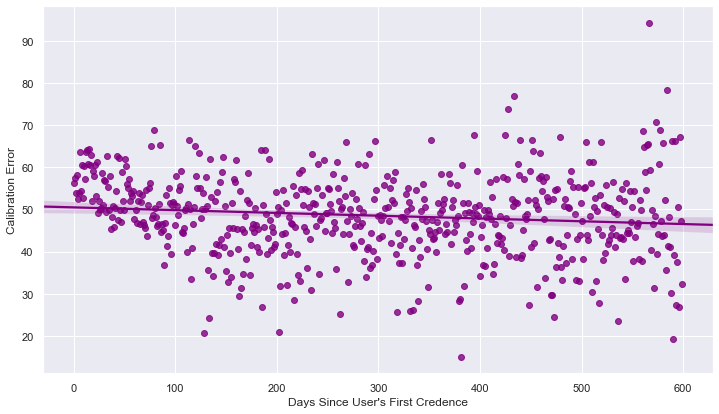

In [40]:
ax = sns.regplot(y=[np.array(an.calibration_score(resolved_credences[i])) for i in range(600)], 
                 x=np.array(range(600)), color='purple')
ax.set(ylabel="Calibration Error", xlabel="Days Since User's First Credence")

ax.get_figure().savefig("../results/calibration.png")

In [16]:
len(np.array([an.calibration_score(resolved_credences[i]) for i in range(10)]))

10

# Word Cloud

https://www.wordclouds.com/

- size: 1920x1080
- gap size: 20
- direction: horizontal
- shape: rectangle (third shape)
- theme: white background, dark grey text
- font: palatino

In [17]:
import spacy
import re

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def event_words(predictions: List[Prediction], top_n: int = None) -> List[str]:
    events = (nlp(p.event) for p in tqdm(predictions))
    tokens = (tok.text.lower() for event in events for tok in event 
              if not tok.is_stop and re.match("\w+", tok.text))
    return [tok for tok, freq in Counter(tokens).most_common(top_n) for _ in range(freq)]

word_list = event_words(preds, top_n=200)
with open("../results/event-words.txt", "w") as f:
    f.write(" ".join(word_list))

100%|██████████| 16092/16092 [00:39<00:00, 412.58it/s]


In [18]:
Counter(word_list)

Counter({'end': 1216,
         '1': 787,
         '2017': 759,
         '2019': 747,
         'year': 705,
         '2016': 668,
         '2012': 630,
         'win': 564,
         '2020': 544,
         'years': 527,
         '2018': 479,
         '2015': 476,
         '10': 445,
         '5': 431,
         'new': 423,
         'week': 396,
         '2013': 385,
         '2': 381,
         'election': 367,
         '3': 360,
         '2014': 342,
         'trump': 330,
         'january': 326,
         'world': 318,
         '2011': 312,
         'president': 297,
         'beat': 297,
         'today': 297,
         'politics': 284,
         'round': 283,
         'time': 276,
         'price': 275,
         'june': 264,
         'mor': 255,
         'complete': 253,
         'hp': 249,
         'rate': 240,
         'hours': 238,
         'prediction': 237,
         'day': 232,
         'average': 231,
         '01': 230,
         'people': 227,
         'season': 227,
         'tomo

In [9]:
bss = brier_scores_by_user(preds)

100%|██████████| 2040/2040 [00:26<00:00, 77.43it/s]


In [13]:
scores = list(bss.values())

In [14]:
np.mean(scores)

0.22285040053339997

In [16]:
np.median(scores)

0.16000000000000003